In [1]:
import json
import os
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

## Imports

In [5]:
image_dir = Path('data/raw/train')
data_dir = Path('data/raw')

In [6]:
df = pd.read_csv(data_dir/'train.csv')

In [7]:
# Get label descriptions
with open(data_dir/'label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
df_categories = pd.DataFrame(label_desc['categories'])
df_attributes = pd.DataFrame(label_desc['attributes'])

In [8]:
df_attributes.sample(10)

,id,name,supercategory,level
75,75,sarong (skirt),nickname,1
152,152,below the knee (length),length,1
160,160,wrist-length,length,1
48,48,track (pants),nickname,1
274,321,camouflage,textile pattern,1
211,211,circular flounce (sleeve),nickname,1
199,199,cowl (neck),neckline type,1
251,298,washed,"textile finishing, manufacturing techniques",1
167,167,mandarin (collar),nickname,1
272,319,cartoon,textile pattern,1


In [9]:
df_categories.sample(10)

,id,name,supercategory,level
16,16,tie,neck,2
6,6,pants,lowerbody,2
22,22,sock,legs and feet,2
40,40,fringe,decorations,2
44,44,sequin,decorations,2
45,45,tassel,decorations,2
27,27,hood,garment parts,2
23,23,shoe,legs and feet,2
25,25,scarf,others,2
31,31,sleeve,garment parts,2


## Attributes

In [10]:
# Group images by encodings, classes and attributes
encodings_classes_df = df.groupby('ImageId')[['EncodedPixels', 'ClassId', 'AttributesIds']].agg(lambda x: list(x))

# Group images by height and width
size_df = df.groupby('ImageId')[['Height', 'Width']].mean()

# Join both df to get a Group by images with all relevant info
image_df = encodings_classes_df.join(size_df, on='ImageId').reset_index()

print("Total images: ", len(image_df))
image_df.head(3)

Total images:  45623


,ImageId,EncodedPixels,ClassId,AttributesIds,Height,Width
0,00000663ed1ff0c4e0132b9b9ac53f6e,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]","[115,136,143,154,230,295,316,317, 115,136,142,...",5214,3676
1,0000fe7c9191fba733c8a69cfaf962b7,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]","[190, 0,115,145,146,295,316,317]",2448,2448
2,0002ec21ddb8477e98b2cbb87ea2e269,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]","[182, 102,128,142,150,229,295,301,318, nan, nan]",3000,1997


In [11]:
# Create dictionaries mapping each number to the category or attribute name
category_name_dict = {}
for i in label_desc["categories"]:
    category_name_dict[str(i["id"])] = i["name"]
category_name_dict = {int(k): v for k, v in category_name_dict.items()}
attribute_name_dict = {}
for i in label_desc["attributes"]:
    attribute_name_dict[str(i["id"])] = i["name"]

In [12]:
# Function will be used for our Attribute Counter
def split_rows(rows):
    if isinstance(rows, str):
        rows = rows.split(',')
    return rows

In [13]:
def map_names_to_numbers(num_dict, mapping_dict):
    mapped_dict = {}
    for i, (key, values) in enumerate(mapping_dict.items()):
        if isinstance(key, int):
            name = num_dict.get(i)
        else: 
            name = num_dict.get(str(i))
        mapped_dict[name] = values
    return mapped_dict

In [14]:
# Create Counters to count the total number of attributes and classes 
counter_category = Counter()
for class_id in df["ClassId"]:
    counter_category.update([class_id])

In [15]:
# Attribute Counter a bit different because we need to account for missing values
counter_attribute = Counter()
for attr in df['AttributesIds'].apply(split_rows):
    # skip the nan values other wise update() causes an error
    if isinstance(attr, float):
        continue
    counter_attribute.update(attr)

In [16]:
mapped_cat_dict = map_names_to_numbers(counter_category, category_name_dict)
mapped_attr_dict = map_names_to_numbers(counter_attribute, attribute_name_dict)

In [17]:
# Reverse keys and values for better readability
mapped_cat_dict = {v: k for k, v in mapped_cat_dict.items()}
mapped_attr_dict = {v: k for k, v in mapped_attr_dict.items()}

In [18]:
# Number of times each category names appears across all masks
mapped_cat_dict

{'shirt, blouse': 6161,
 'top, t-shirt, sweatshirt': 16548,
 'sweater': 1494,
 'cardigan': 1107,
 'jacket': 7833,
 'vest': 719,
 'pants': 12414,
 'shorts': 2756,
 'skirt': 5046,
 'coat': 3124,
 'dress': 18739,
 'jumpsuit': 922,
 'cape': 152,
 'glasses': 4855,
 'hat': 2518,
 'headband, head covering, hair accessory': 3470,
 'tie': 1457,
 'glove': 1385,
 'watch': 3389,
 'belt': 6851,
 'leg warmer': 112,
 'tights, stockings': 4326,
 'sock': 2582,
 'shoe': 46374,
 'bag, wallet': 7217,
 'scarf': 1374,
 'umbrella': 135,
 'hood': 1226,
 'collar': 10159,
 'lapel': 5972,
 'epaulette': 874,
 'sleeve': 59448,
 'pocket': 27179,
 'neckline': 34258,
 'buckle': 3300,
 'zipper': 7991,
 'applique': 3529,
 'bead': 5084,
 'bow': 528,
 'flower': 1367,
 'fringe': 588,
 'ribbon': 274,
 'rivet': 4893,
 'ruffle': 2407,
 'sequin': 929,
 'tassel': 335}

In [19]:
# Number of times each attributes appear across all masks
mapped_attr_dict

{'classic (t-shirt)': 5466,
 'bermuda (shorts)': 198,
 'undershirt': 573,
 'henley (shirt)': 81,
 'ringer (t-shirt)': 79,
 'raglan (t-shirt)': 172,
 'bow (collar)': 96,
 'peter pan (collar)': 213,
 'crop (top)': 1105,
 'halter (top)': 360,
 'camisole': 1041,
 'tank (top)': 2182,
 'track (jacket)': 238,
 'tube (top)': 475,
 'tunic (top)': 411,
 'smock (top)': 87,
 'hoodie': 414,
 'blazer': 2900,
 'pea (jacket)': 47,
 'puffer (jacket)': 159,
 'biker (jacket)': 1043,
 'trucker (jacket)': 445,
 'bomber (jacket)': 322,
 'toile de jouy': 24,
 'safari (jacket)': 83,
 'mao (jacket)': 3,
 'raincoat': 12,
 'ball gown (skirt)': 125,
 'asymmetric (collar)': 44,
 'windbreaker': 82,
 'jodhpur': 85,
 'bolero': 94,
 'tuxedo (jacket)': 424,
 'crop (jacket)': 128,
 'jeans': 3764,
 'sweatpants': 115,
 'leggings': 1787,
 'hip-huggers (pants)': 103,
 'cargo (pants)': 67,
 'culottes': 178,
 'capri (pants)': 183,
 'harem (pants)': 53,
 'sailor (pants)': 283,
 'peg (pants)': 269,
 'camo (pants)': 23,
 'tulip 

### Category and Attribute Frequency

In [20]:
# Function to make the printing pretty
def print_dict(dictionary, name_dict):
    print("{}{}{}{}{}".format("rank".ljust(5), "id".center(8), "name".center(40), "amount".rjust(10), "ratio(%)".rjust(10)))
    all_num = sum(dictionary.values())
    for i, (key, val) in enumerate(sorted(dictionary.items(), key=lambda x: -x[1])):
        print("{:<5}{:^8}{:^40}{:>10}{:>10.3%}".format(i+1, key, name_dict[key], val, val/all_num))


In [21]:
print_dict(counter_attribute, attribute_name_dict)

rank    id                     name                      amount  ratio(%)
1      295           no non-textile material              65854    8.648%
2      115                 symmetrical                    60164    7.901%
3      317               plain (pattern)                  58468    7.678%
4      204                set-in sleeve                   39004    5.122%
5      316      no special manufacturing technique        38349    5.036%
6      160                 wrist-length                   34135    4.483%
7      142                 normal waist                   25019    3.285%
8      136                regular (fit)                   24669    3.239%
9      145                 no waistline                   18942    2.487%
10     146            above-the-hip (length)              17444    2.291%
11     229                    zip-up                      16859    2.214%
12     135                 tight (fit)                    13473    1.769%
13     157                short (lengt

In [117]:
print_dict(counter_category, category_name_dict)

rank    id                     name                      amount  ratio(%)
1       31                    sleeve                      59448   17.831%
2       23                     shoe                       46374   13.909%
3       33                   neckline                     34258   10.275%
4       32                    pocket                      27179    8.152%
5       10                    dress                       18739    5.621%
6       1            top, t-shirt, sweatshirt             16548    4.963%
7       6                     pants                       12414    3.723%
8       28                    collar                      10159    3.047%
9       35                    zipper                       7991    2.397%
10      4                     jacket                       7833    2.349%
11      24                 bag, wallet                     7217    2.165%
12      19                     belt                        6851    2.055%
13      0                 shirt, blous

## Supercategories

In [30]:
attr_order = df_attributes['supercategory'].value_counts().index
cat_order = df_categories['supercategory'].value_counts().index

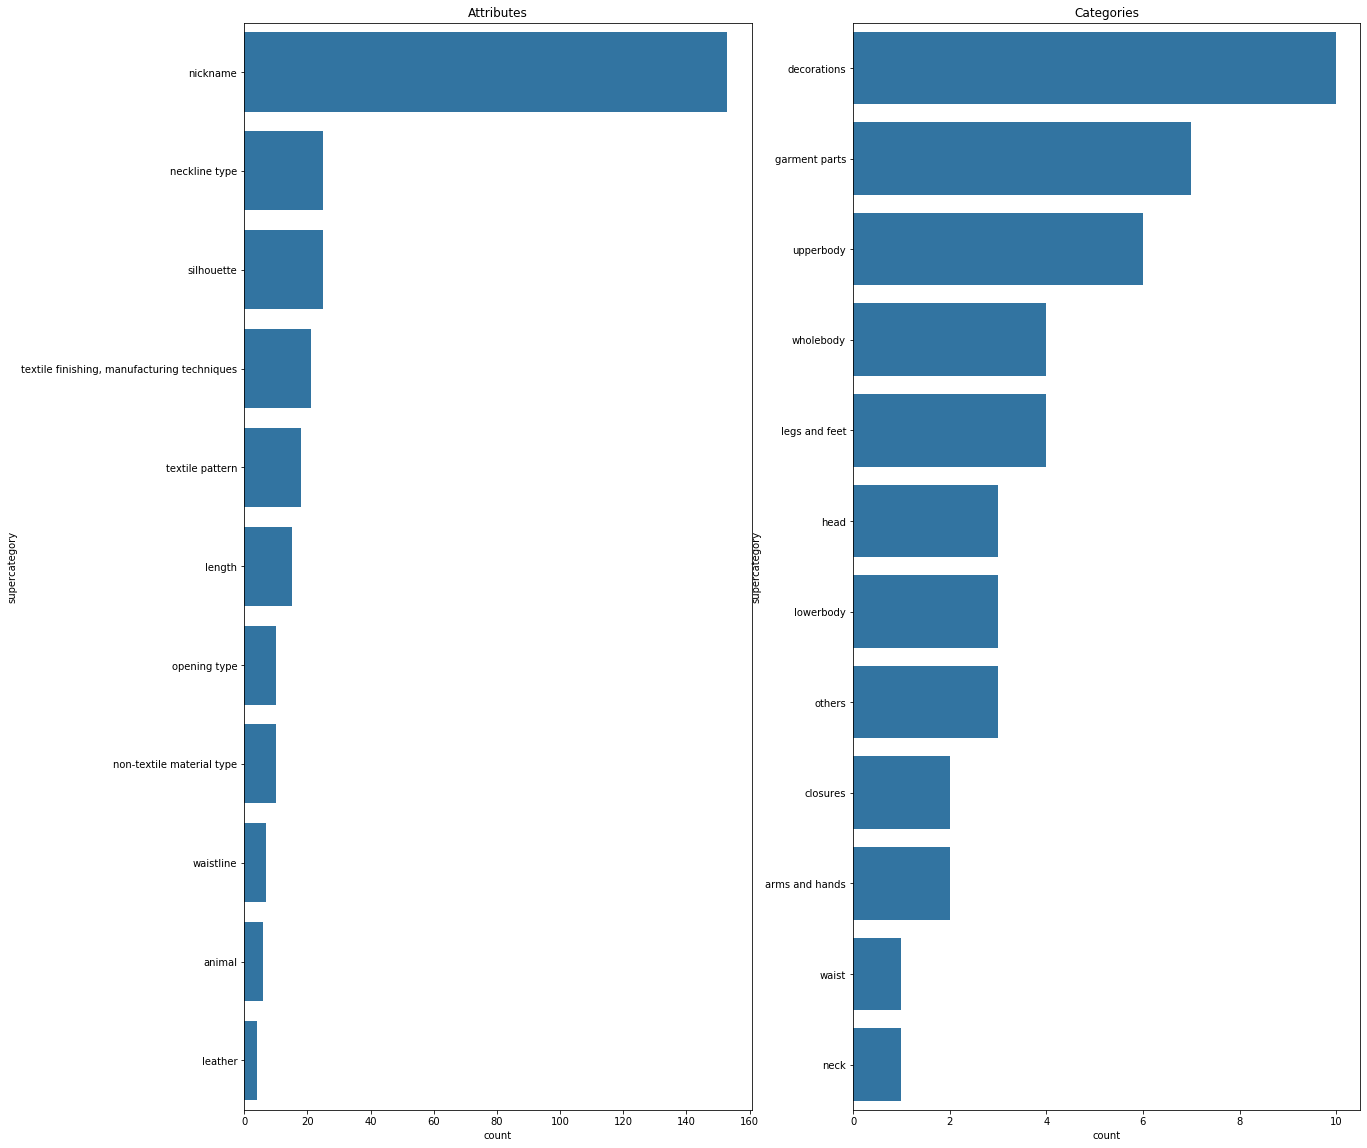

In [32]:
fig,ax = plt.subplots(1,2,figsize = (20,20))
base_color = sns.color_palette()[0]
sns.countplot(y='supercategory', data = df_attributes, ax = ax[0], orient='v', color=base_color, order=attr_order)
sns.countplot(y='supercategory', data = df_categories, ax = ax[1], orient='v', color=base_color, order=cat_order)
ax[0].set_title('Attributes')
ax[1].set_title('Categories')
plt.show()

### Group category supercategories

In [42]:
df_cat_supercategories = pd.DataFrame(df_categories.groupby('supercategory')['name'].agg(lambda x: list(x))).reset_index()

In [43]:
df_cat_supercategories

,supercategory,name
0,arms and hands,"[glove, watch]"
1,closures,"[buckle, zipper]"
2,decorations,"[applique, bead, bow, flower, fringe, ribbon, ..."
3,garment parts,"[hood, collar, lapel, epaulette, sleeve, pocke..."
4,head,"[glasses, hat, headband, head covering, hair a..."
5,legs and feet,"[leg warmer, tights, stockings, sock, shoe]"
6,lowerbody,"[pants, shorts, skirt]"
7,neck,[tie]
8,others,"[bag, wallet, scarf, umbrella]"
9,upperbody,"[shirt, blouse, top, t-shirt, sweatshirt, swea..."


### Group Attribute supercategories

In [44]:
df_attr_supercategories = pd.DataFrame(df_attributes.groupby('supercategory')['name'].agg(lambda x: list(x))).reset_index()

In [45]:
df_attr_supercategories

,supercategory,name
0,animal,"[leopard, snakeskin (pattern), cheetah, peacoc..."
1,leather,"[suede, shearling, crocodile, snakeskin]"
2,length,"[above-the-hip (length), hip (length), micro (..."
3,neckline type,"[collarless, asymmetric (neckline), crew (neck..."
4,nickname,"[classic (t-shirt), polo (shirt), undershirt, ..."
5,non-textile material type,"[plastic, rubber, metal, feather, gem, bone, i..."
6,opening type,"[single breasted, double breasted, lace up, wr..."
7,silhouette,"[asymmetrical, symmetrical, peplum, circle, fl..."
8,"textile finishing, manufacturing techniques","[burnout, distressed, washed, embossed, frayed..."
9,textile pattern,"[plain (pattern), abstract, cartoon, letters, ..."


### Get supercateogie count across all masks and images

In [192]:
counter = 1
counter += mapped_attr_dict.get('clfdfdfdt-shirt)', 1)
counter

2

In [202]:
cat_count_map = {}
for n, c in df_cat_supercategories.iterrows():
    counter = 0
    for item in c['name']:
        counter += mapped_cat_dict[item] 
        cat_count_map[n] = counter 

In [203]:
counter_map

{0: 4774,
 1: 11291,
 2: 19934,
 3: 139116,
 4: 10843,
 5: 53394,
 6: 20216,
 7: 1457,
 8: 8726,
 9: 33862,
 10: 6851,
 11: 22937}

In [204]:
df_cat_supercategories['Count'] = counter_map.values()

In [205]:
df_cat_supercategories

,supercategory,name,Count
0,arms and hands,"[glove, watch]",4774
1,closures,"[buckle, zipper]",11291
2,decorations,"[applique, bead, bow, flower, fringe, ribbon, ...",19934
3,garment parts,"[hood, collar, lapel, epaulette, sleeve, pocke...",139116
4,head,"[glasses, hat, headband, head covering, hair a...",10843
5,legs and feet,"[leg warmer, tights, stockings, sock, shoe]",53394
6,lowerbody,"[pants, shorts, skirt]",20216
7,neck,[tie],1457
8,others,"[bag, wallet, scarf, umbrella]",8726
9,upperbody,"[shirt, blouse, top, t-shirt, sweatshirt, swea...",33862


**WIP**

## Levels

In [12]:
df_attributes.level.value_counts()

1    284
2     10
Name: level, dtype: int64

In [13]:
df_categories.level.value_counts()

2    46
Name: level, dtype: int64

## Image Shapes

In [15]:
image_shape_df = df.groupby("ImageId")[["Height", "Width"]].first()

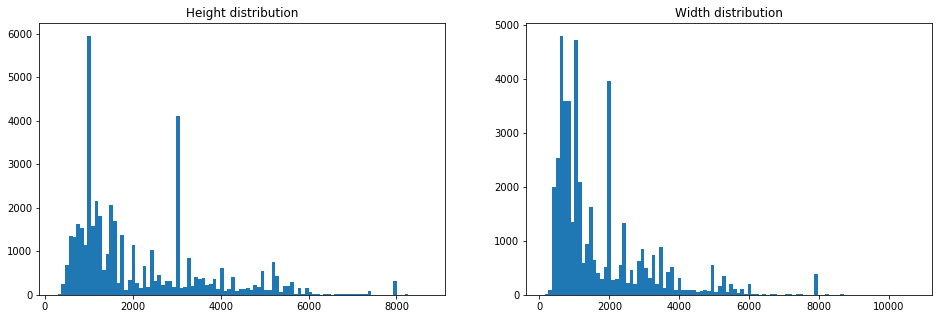

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
ax1.hist(image_shape_df.Height, bins=100)
ax1.set_title("Height distribution")
ax2.hist(image_shape_df.Width, bins=100)
ax2.set_title("Width distribution");

In [12]:
image_df.head()

,ImageId,EncodedPixels,ClassId,AttributesIds,Height,Width
0,00000663ed1ff0c4e0132b9b9ac53f6e,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]","[115,136,143,154,230,295,316,317, 115,136,142,...",5214,3676
1,0000fe7c9191fba733c8a69cfaf962b7,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]","[190, 0,115,145,146,295,316,317]",2448,2448
2,0002ec21ddb8477e98b2cbb87ea2e269,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]","[182, 102,128,142,150,229,295,301,318, nan, nan]",3000,1997
3,0002f5a0ebc162ecfb73e2c91e3b8f62,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]","[108,115,119,141,155,229,286,316,317, 187, nan]",567,400
4,0004467156e47b0eb6de4aa6479cbd15,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]","[115,141,155,295,305,317, 188, 159, 159, nan]",750,500


In [20]:
df.sort_values('ClassId')[50000:70000]

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
115087,58562f033153ed9c967cf51c766745ec,994930 2 996928 7 998926 12 1000925 16 1002923...,2000,1158,8,"120,143,149,295,304,317"
302876,e90cbde940e8e5a6ddc6ed84d5f936b1,610065 5 611557 14 613050 22 614543 29 616036 ...,1500,1000,8,"115,118,142,151,234,295,316,317"
115069,585087ca6db4b9011e2d89a4c4b3bd28,530981 2 532578 7 534175 11 535772 15 537369 1...,1600,1067,8,"68,115,127,141,153,295,309,326"
82224,3ef030621581cf60c25a9d9268a8af0f,483080 34 485870 94 488660 147 491450 200 4942...,2800,2100,8,"68,128,142,151,295,316,326"
193506,9520b2f13b44f55e16a8a0bbb5dbb234,266344 10 267301 28 268260 43 269219 59 270163...,960,640,8,"68,115,126,151,229,295,316,317"
...,...,...,...,...,...,...
312852,f0b33b338f35306967f6da4e7e1b264e,2392444 141 2394726 1 2395441 151 2397725 4 23...,3000,1997,10,"102,115,128,142,149,295,317"
274440,d32b6162f50b760180d845dc270ed5aa,656558 4 659554 10 662549 17 665544 24 668539 ...,3000,2001,10,"108,115,117,141,155,229,295,311,324"
154997,7701f63dce5c2a5973fe550e60aa74d0,289821 3 290954 4 292087 5 293219 7 294352 8 2...,1133,1502,10,"101,115,129,139,149,229,295,316,327"
154999,7706b58f1d6fdceeb480ff27261d4f46,59326 29 60324 41 61322 51 62320 60 63319 68 6...,1000,665,10,"102,128,141,151,316,317"
